In [2]:
from fastai.tabular import *
from fastai.metrics import accuracy
from fastai.layers import BCEWithLogitsFlat
import pandas as pd
import numpy as np

In [3]:
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn

In [4]:
from functional import seq

In [44]:
trn_df = pd.read_csv('train.csv',index_col='ID_code')
tst_df = pd.read_csv('test.csv',index_col='ID_code')

In [45]:
procs = [ Normalize]

In [46]:
# normalize the df

In [47]:
data = (TabularList.from_df(trn_df,procs=procs,cont_names=tst_df.columns)
        .split_by_rand_pct(0.33,seed=42)
       .label_from_df('target')
       .add_test(TabularList.from_df(tst_df))
       .databunch(num_workers=16))

In [17]:
#k = next(iter(data.train_dl));
#k

[[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
  tensor([[ 1.0905, -1.2145,  0.5031,  ...,  1.4210,  0.2814,  1.4847],
          [-1.1265,  2.2213, -1.0862,  ..., -0.7668, -0.0143, -1.8482],
          [-0.3081,  2.4184,  1.2020,  ...,  1.5495,  1.5901, -0.9573],
          ...,
          [-0.9289, -0.6391,  0.4847,  ..., -0.3312, -0.1955,  0.1987],
          [ 1.7289,  1.8599, -1.5204,  ...,  0.3367,  0.2248, -0.3167],
          [-0.6244,  2.3960,  1.0766,  ...,  0.2556, -1.0343,  1.5694]],
         device='cuda:0')],
 tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')]

In [13]:
#valid_ids_ = range(len(trn_df)-50000,len(trn_df))
#data_ = TabularDataBunch.from_df('.',trn_df,dep_var='target',valid_idx=valid_ids_,test_df=tst_df,bs=128)

In [14]:
#j = next(iter(data_.train_dl));
#j

[[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
  tensor([[15.0299,  6.2215, -0.7106,  ..., -1.4093, 23.9147, 12.3522],
          [13.8551,  6.1606, -0.6090,  ...,  2.3456, 24.7512,  4.2253],
          [15.6720,  7.1837,  0.4743,  ...,  2.9052, 23.8187, 20.5838],
          ...,
          [17.2064,  6.6850, -0.8227,  ...,  6.0430, 11.2768, 27.4814],
          [16.3001,  6.8561, -0.2898,  ..., -7.8753, 21.4042, 25.5600],
          [22.5148,  6.2329, -0.0651,  ...,  5.7684, 11.8820, 19.8031]],
         device='cuda:0')],
 tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [12]:
np.unique(data.train_ds.y.items,return_counts=True)

(array([0, 1]), array([120656,  13344]))

In [80]:
def is_even(num): return num % 2 == 0

class SiamDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds
        self.targets = ds.y.items
        self.candidates_1 = list(np.where(self.targets == 1)[0])
        self.candidates_0 = list(np.where(self.targets == 0)[0])
        self.candidates = [self.candidates_0,self.candidates_1]
    def __len__(self):
        return 2 * len(self.ds)
    def __getitem__(self, idx):
        if is_even(idx):
            return self.sample_same(idx // 2)
        else: return self.sample_different((idx-1) // 2)
    def sample_same(self, idx):
        target_val = self.targets[idx]        
        #candidates = list(np.where(self.targets == target_val)[0])
        #candidates.remove(idx) # dropping our current whale - we don't want to compare against an identical image!
        
        #if len(candidates) == 0: # oops, there is only a single whale with this id in the dataset
            #return self.sample_different(idx)
        
        #np.random.shuffle(candidates)
        self.pick = np.random.randint(0,len(self.candidates[ target_val ]))
        return self.construct_example(self.ds[idx][0], self.ds[self.candidates[target_val][self.pick]][0], 1)
    def sample_different(self, idx):
        target_val = self.targets[idx]
        #candidates = list(np.where(self.targets != target_val)[0])
        #np.random.shuffle(candidates)
        self.pick = np.random.randint(0,len(self.candidates[ (target_val+1)%2 ]))
        return self.construct_example(self.ds[idx][0], self.ds[self.candidates[(target_val+1)%2][self.pick]][0], 0)
    
    def construct_example(self, A, B, class_idx):
        return [A, B], class_idx

In [69]:
1%2

1

In [41]:
np.random.randint(0,10)

4

In [9]:
np.where(data.train_ds.y.items == 1)

(array([     8,     21,     45,     47, ..., 133976, 133986, 133989, 133992]),)

In [81]:
bs = 256
num_workers = 16

In [82]:
trn_dl = DataLoader(SiamDataset(data.train_ds),
                   batch_size=bs
                    ,num_workers=num_workers)
val_dl = DataLoader(SiamDataset(data.valid_ds),
                   batch_size=bs
                    ,num_workers=num_workers)

In [83]:
s = SiamDataset(data.train_ds)

In [84]:
s[206]

([TabularLine var_0 -0.8693; var_1 0.8661; var_2 -0.2253; var_3 -1.5639; var_4 0.6154; var_5 -0.7486; var_6 -1.8228; var_7 -0.6223; var_8 -0.9859; var_9 0.3775; var_10 0.1710; var_11 -0.5365; var_12 0.9363; var_13 1.0369; var_14 -0.6000; var_15 1.0593; var_16 -0.6739; var_17 -0.2802; var_18 0.4533; var_19 1.2607; var_20 -0.3293; var_21 -0.3969; var_22 -1.6681; var_23 0.0650; var_24 -0.7148; var_25 0.8210; var_26 0.8769; var_27 0.6192; var_28 -1.1695; var_29 2.4550; var_30 0.7859; var_31 -1.0032; var_32 -0.9985; var_33 -0.1363; var_34 -0.5875; var_35 -0.8005; var_36 0.1603; var_37 0.3143; var_38 0.2617; var_39 -0.0058; var_40 1.0563; var_41 0.0943; var_42 -1.5013; var_43 -2.5895; var_44 -1.0111; var_45 0.2178; var_46 1.2080; var_47 0.6370; var_48 -1.2786; var_49 -1.4410; var_50 -0.8669; var_51 -0.4558; var_52 0.6003; var_53 -1.5434; var_54 1.3314; var_55 -1.4027; var_56 -1.6567; var_57 -1.3180; var_58 -1.6830; var_59 0.6518; var_60 -0.0590; var_61 -0.0952; var_62 -0.4788; var_63 0.1259;

In [85]:
dbunch = TabularDataBunch(trn_dl,val_dl)

In [86]:
class linrelbn(nn.Module):
    def __init__(self,x,y):
        super().__init__()
        self.lin = nn.Linear(x,y)
        self.rel = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm1d(y)
        #self.net = nn.Sequential(self.lin,self.rel,self.)
    def forward(self,A):
        return  self.bn(self.rel(self.lin(A)))

In [14]:
list(range(0,3))

[0, 1, 2]

In [87]:
class SiamModel(nn.Module):
    def __init__(self,lyrwds):
        super().__init__()
        self.net_ = nn.Sequential(*[linrelbn(lyrwds[i],lyrwds[i+1]) for i in range(0,len(lyrwds)-1)])
        self.head = nn.Linear(2,1)
        
    def forward(self,A,B):
        x1,x2 = seq(A[1],B[1]).map(self.net_)
        return self.head(x1-x2)
        

In [88]:
model = SiamModel([200,350,200,64,8,2]);
model

SiamModel(
  (net_): Sequential(
    (0): linrelbn(
      (lin): Linear(in_features=200, out_features=350, bias=True)
      (rel): ReLU(inplace)
      (bn): BatchNorm1d(350, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): linrelbn(
      (lin): Linear(in_features=350, out_features=200, bias=True)
      (rel): ReLU(inplace)
      (bn): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): linrelbn(
      (lin): Linear(in_features=200, out_features=64, bias=True)
      (rel): ReLU(inplace)
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): linrelbn(
      (lin): Linear(in_features=64, out_features=8, bias=True)
      (rel): ReLU(inplace)
      (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): linrelbn(
      (lin): Linear(in_features=8, out_features=2, bias=True)
      (rel): ReLU(inplace)
      (bn): BatchNorm1

In [91]:
learn = Learner(dbunch,model,loss_func=BCEWithLogitsFlat(),metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [82]:
#a = next(iter(learn.data.train_dl));
#a

[[[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
   tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')],
  [tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
   tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')]],
 tensor([1, 0, 1, 0, 

In [56]:
x,y = a

In [81]:
len(x[0][0])

64

In [84]:
learn.data.train_ds[0][0][0].data

[tensor(0), tensor(0)]

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


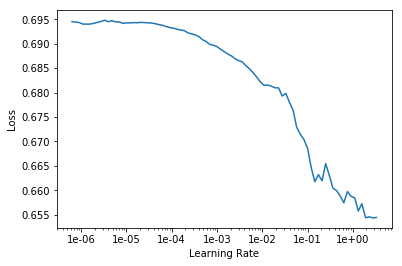

In [29]:
learn.recorder.plot()

In [92]:
learn.fit_one_cycle(20,max_lr=.1)

epoch,train_loss,valid_loss,,time
0,0.607154,3.077572,0.572409,00:13
1,0.591552,0.762951,0.575364,00:13
2,0.570579,0.709787,0.585409,00:13
3,0.604286,0.680793,0.529364,00:13
4,0.596273,1.877978,0.524364,00:13
5,0.601909,0.643336,0.527076,00:13
6,0.627916,0.646795,0.533091,00:13
7,0.605671,0.642587,0.555788,00:13
8,0.598641,0.668724,0.549417,00:13
9,0.623846,0.661785,0.569136,00:13
